### Approach 3: CNN and DNN

In [1]:
import pandas as pd

In [2]:
# Read the CSV file
df = pd.read_csv('/kaggle/input/sbd-data/dataset.csv')

df.head()

,id,text,lemma,upos,xpos,head,deprel,start_char,end_char
0,1,اس,یہ,DET,DEM,2,det,0,2
1,2,سلسلے,سلسلہ,NOUN,NN,5,nmod,3,8
2,3,کی,کا,ADP,PSP,2,case,9,11
3,4,دیگر,دیگر,ADJ,JJ,5,amod,12,16
4,5,اقساط,اقساط,NOUN,NN,7,nsubj,17,22


In [3]:
data = df.drop(columns=['id'])

In [4]:
import string
import re

In [5]:
# Initialize a new column 'y' with the default value 'S_M'
data['y'] = 'S_M'

# Iterate through the rows to assign 'S_B'
for i in range(len(data) - 1):
    # Check if the current word ends with a full stop
    if data.loc[i, 'text'].endswith('۔'):
        # Assign 'S_B' to the next word
        if i + 1 < len(data):
            data.loc[i + 1, 'y'] = 'S_B'  # Sentence Beginning

# Convert 'y' column to categorical type (optional, for ML efficiency)
data['y'] = data['y'].astype('category')

# Map categorical labels to numeric values
label_mapping = {'S_B': 1, 'S_M': 0}
data['y'] = data['y'].map(label_mapping)

# Verify the result
data.head(10)

,text,lemma,upos,xpos,head,deprel,start_char,end_char,y
0,اس,یہ,DET,DEM,2,det,0,2,0
1,سلسلے,سلسلہ,NOUN,NN,5,nmod,3,8,0
2,کی,کا,ADP,PSP,2,case,9,11,0
3,دیگر,دیگر,ADJ,JJ,5,amod,12,16,0
4,اقساط,اقساط,NOUN,NN,7,nsubj,17,22,0
5,یہاں,یہاں,PRON,PRP,7,obl,23,27,0
6,پڑھیے,پڑھ,VERB,VM,0,root,28,33,0
7,۔,۔,PUNCT,SYM,7,punct,33,34,0
8,یہ,یہ,PRON,PRP,3,nsubj,36,38,1
9,کیسے,کیسا,PRON,WQ,3,advmod,39,43,0


In [6]:
# Drop rows where the 'text' column contains only punctuation
data = data[~data['text'].str.contains(r'^[^\w\s]+$', na=False)]

# Verify the result
data.head(10)


,text,lemma,upos,xpos,head,deprel,start_char,end_char,y
0,اس,یہ,DET,DEM,2,det,0,2,0
1,سلسلے,سلسلہ,NOUN,NN,5,nmod,3,8,0
2,کی,کا,ADP,PSP,2,case,9,11,0
3,دیگر,دیگر,ADJ,JJ,5,amod,12,16,0
4,اقساط,اقساط,NOUN,NN,7,nsubj,17,22,0
5,یہاں,یہاں,PRON,PRP,7,obl,23,27,0
6,پڑھیے,پڑھ,VERB,VM,0,root,28,33,0
8,یہ,یہ,PRON,PRP,3,nsubj,36,38,1
9,کیسے,کیسا,PRON,WQ,3,advmod,39,43,0
10,ممکن,ممکن,ADJ,JJ,0,root,44,48,0


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
# One-hot encode 'upos', 'xpos', and 'deprel'
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(data[['upos', 'xpos', 'deprel']])

# Convert to DataFrame for easier merging
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

# Concatenate encoded features back to the dataset
data = pd.concat([data.reset_index(drop=True), encoded_cats_df], axis=1)

# Drop the original categorical columns (optional)
data = data.drop(columns=['upos', 'xpos', 'deprel'])

In [9]:
# Select the numerical features to normalize
numerical_features = ['start_char', 'end_char', 'head']

from sklearn.preprocessing import MinMaxScaler

# Option 2: Min-Max Scaling (scales features to a range, typically 0 to 1)
min_max_scaler = MinMaxScaler()
data[numerical_features] = min_max_scaler.fit_transform(data[numerical_features])

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine text and lemma columns into a single string representation (if needed)
data['text_lemma'] = data['text'] + " " + data['lemma']

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Adjust max_features as needed

# Fit and transform the combined text and lemma
tfidf_features = tfidf_vectorizer.fit_transform(data['text_lemma'])

# Convert the sparse matrix to a DataFrame for better integration
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add the TF-IDF features back to the original DataFrame
data = pd.concat([data.reset_index(drop=True), tfidf_df], axis=1)

# Drop the original text and lemma columns (optional)
data = data.drop(columns=['text', 'lemma', 'text_lemma'])

In [11]:
data.head(10)

,head,start_char,end_char,y,upos_ADJ,upos_ADP,upos_ADV,upos_AUX,upos_CCONJ,upos_DET,...,ہوں,ہی,ہیں,ہے,یا,یعنی,یقینا,یہ,یہاں,یہی
0,0.014493,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.646062,0.0,0.0
1,0.036232,0.000003,0.000005,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.014493,0.000008,0.000008,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.036232,0.000011,0.000012,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.050725,0.000015,0.000018,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.050725,0.000020,0.000022,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0
6,0.000000,0.000025,0.000027,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.021739,0.000032,0.000032,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
8,0.021739,0.000035,0.000036,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.000000,0.000039,0.000041,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [12]:
# Define the feature matrix (drop 'y') and target
X = data.drop(columns=['y'])
y = data['y']


In [13]:
# Split into training (64%), validation (16%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.36, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.56, random_state=42, stratify=y_temp)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Compute class weights based on the class distribution in the target variable y
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [16]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [17]:
# Convert data to NumPy arrays
X_train_resampled = np.array(X_train_resampled)
y_train_resampled = np.array(y_train_resampled)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [19]:
# Define the DNN model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_resampled.shape[1]),  # Input layer
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),  # Hidden layer
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),  # Hidden layer
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


Epoch 1/10


I0000 00:00:1735307625.350290     100 service.cc:145] XLA service 0x5adee2cafd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735307625.350353     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1735307625.350359     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  93/9271 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6414 - loss: 4.1442  

I0000 00:00:1735307630.459440     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9271/9271 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.7764 - loss: 0.7360 - val_accuracy: 0.7600 - val_loss: 0.7630
Epoch 2/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8573 - loss: 0.3522 - val_accuracy: 0.7678 - val_loss: 0.7765
Epoch 3/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8714 - loss: 0.3182 - val_accuracy: 0.7771 - val_loss: 0.6929
Epoch 4/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8734 - loss: 0.3091 - val_accuracy: 0.7930 - val_loss: 0.6960
Epoch 5/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8766 - loss: 0.3014 - val_accuracy: 0.7752 - val_loss: 0.7607
Epoch 6/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8788 - loss: 0.2902 - val_accuracy: 0.7892 - val_loss: 0.6770
Epoch 7/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8810 - loss: 0.2846 - val_accuracy: 0.7884 - val_loss: 0.7328
Epoch 8/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8858 - loss: 0.2741 - val

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


1517/1517 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7928 - loss: 0.6624
Test Loss: 0.671063244342804
Test Accuracy: 0.7911173105239868
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88     46727
           1       0.15      0.99      0.26      1817

    accuracy                           0.79     48544
   macro avg       0.58      0.89      0.57     48544
weighted avg       0.97      0.79      0.86     48544

Confusion Matrix:
 [[36606 10121]
 [   19  1798]]


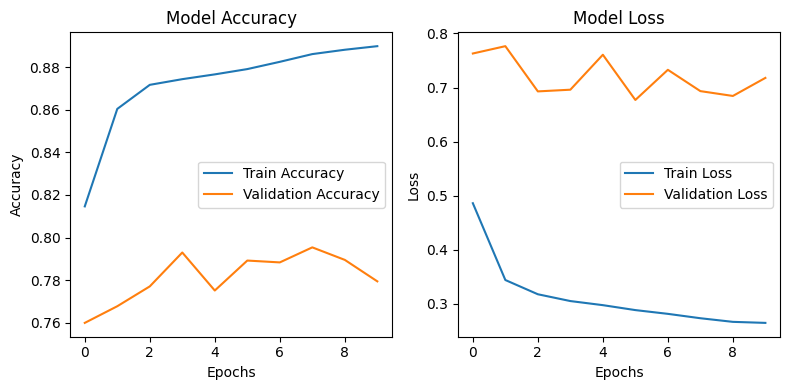

In [22]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(8, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [115]:
# Define CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_resampled.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Flatten the feature map for fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

# Display model architecture
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 576, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 576, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 288, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 286, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 286, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 143, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18304)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     2,343,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,377,089 (9.07 MB)

 Trainable params: 2,376,705 (9.07 MB)

 Non-trainable params: 384 (1.50 KB)

In [116]:
# Reshape input data for CNN
X_train_resampled = X_train_resampled.values.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_val = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)


In [117]:
# Convert target variables to numeric arrays
y_train_resampled = y_train_resampled.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

# Convert feature matrices to numpy arrays
X_train_resampled = X_train_resampled.astype('float32').reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_val = X_val.astype('float32').reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.astype('float32').reshape(X_test.shape[0], X_test.shape[1], 1)

In [118]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=[early_stopping]
)

Epoch 1/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.6934 - loss: 0.8716 - val_accuracy: 0.6661 - val_loss: 1.0214
Epoch 2/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.7725 - loss: 0.4100 - val_accuracy: 0.9506 - val_loss: 0.3885
Epoch 3/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.8013 - loss: 0.4026 - val_accuracy: 0.7031 - val_loss: 0.7183
Epoch 4/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.8242 - loss: 0.4044 - val_accuracy: 0.6493 - val_loss: 0.8688
Epoch 5/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.8216 - loss: 0.4047 - val_accuracy: 0.5603 - val_loss: 1.3011
Epoch 6/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.8256 - loss: 0.3892 - val_accuracy: 0.9688 - val_loss: 0.1337
Epoch 7/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.8110 - loss: 0.4140 - val_accuracy: 0.6069 - val_loss: 1.0009
Epoch 8/10
9271/9271 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.8342 - loss: 0

In [119]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and evaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

1517/1517 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9687 - loss: 0.1351
Test Loss: 0.1368279755115509
Test Accuracy: 0.9679465889930725
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     46727
         1.0       0.58      0.55      0.56      1817

    accuracy                           0.97     48544
   macro avg       0.78      0.77      0.77     48544
weighted avg       0.97      0.97      0.97     48544

[[45993   734]
 [  822   995]]
